In [4]:
from rdkit import Chem
from rdkit import RDLogger
import matplotlib.pyplot as plt
import pandas as pd
import gzip
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski
import seaborn as sb

In [5]:
RDLogger.DisableLog('rdApp.error')

In [6]:
supp = Chem.SDMolSupplier('../data/drugbank.sdf')
drug_bank = [[mol, 'DrugBank'] for mol in supp if mol]

with gzip.open('actives_final.sdf.gz') as sdf:
    supp_actives = Chem.ForwardSDMolSupplier(sdf)
    actives = [[mol, 'actives'] for mol in supp_actives if mol]

with gzip.open('decoys_final.sdf.gz') as sdf:
    supp_decoys = Chem.ForwardSDMolSupplier(sdf)
    decoys = [[mol, 'decoys'] for mol in supp_decoys if mol]

RDKit WARNING: [13:03:51] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[13:03:51] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


In [7]:
df_db = pd.DataFrame(drug_bank, columns=['Mol', 'Source'])
df_ac = pd.DataFrame(actives, columns=['Mol', 'Source'])
df_de = pd.DataFrame(decoys, columns=['Mol', 'Source'])

df = pd.concat((df_db, df_ac, df_de), ignore_index=True)
df

,Mol,Source
0,<rdkit.Chem.rdchem.Mol object at 0x7f5c02b6f670>,DrugBank
1,<rdkit.Chem.rdchem.Mol object at 0x7f5c02b6f6c0>,DrugBank
2,<rdkit.Chem.rdchem.Mol object at 0x7f5c02b6f710>,DrugBank
3,<rdkit.Chem.rdchem.Mol object at 0x7f5c02b6f760>,DrugBank
4,<rdkit.Chem.rdchem.Mol object at 0x7f5c02b6f7b0>,DrugBank
...,...,...
36236,<rdkit.Chem.rdchem.Mol object at 0x7f5c025ea8a0>,decoys
36237,<rdkit.Chem.rdchem.Mol object at 0x7f5c025ea940>,decoys
36238,<rdkit.Chem.rdchem.Mol object at 0x7f5c025ea9e0>,decoys
36239,<rdkit.Chem.rdchem.Mol object at 0x7f5c025eaa80>,decoys


In [8]:
import itertools
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

def visualize_match(structure, pattern):
    # GetSubstructMatches grabs all hits, GetSubstructMatch the first one it finds
    hits = structure.GetSubstructMatches(pattern)
    hit_atoms = set()
    hit_bonds = set()
    for hit in hits:
        hit_atoms.update(hit)
        hit_bonds.update([structure.GetBondBetweenAtoms(i, j).GetIdx()
                          for i, j in itertools.combinations(hit_atoms, 2)
                          if structure.GetBondBetweenAtoms(i, j)])
    d = rdMolDraw2D.MolDraw2DSVG(300,300)
    rdMolDraw2D.PrepareAndDrawMolecule(d, structure, highlightAtoms=hit_atoms, highlightBonds=hit_bonds)
    d.FinishDrawing()
    display(SVG(d.GetDrawingText()))

In [33]:
cooh_pattern = Chem.MolFromSmarts('C(=O)[O;h1]')
ar = Chem.MolFromSmarts('cccccc')
salicylic_acid_pattern = Chem.MolFromSmarts('c1ccc(c(c1)C(=O)O)O')

hits_cooh = []
hits_ar = []
hits_sal = []

for mol in df['Mol']:
    hit = mol.GetSubstructMatches(cooh_pattern)
    hits_cooh.append(len(hit))

df['cooh'] = hits_cooh

for mol in df['Mol']:
    hit = mol.GetSubstructMatches(ar)
    hits_ar.append(len(hit))

df['ar'] = hits_ar

for mol in df['Mol']:
    hit = mol.GetSubstructMatches(salicylic_acid_pattern)
    hits_sal.append(len(hit))

df['sal'] = hits_sal

In [34]:
df

,Mol,Source,cooh,ar,sal
0,<rdkit.Chem.rdchem.Mol object at 0x7f5c02b6f670>,DrugBank,6,3,0
1,<rdkit.Chem.rdchem.Mol object at 0x7f5c02b6f6c0>,DrugBank,0,6,0
2,<rdkit.Chem.rdchem.Mol object at 0x7f5c02b6f710>,DrugBank,0,2,0
3,<rdkit.Chem.rdchem.Mol object at 0x7f5c02b6f760>,DrugBank,0,18,0
4,<rdkit.Chem.rdchem.Mol object at 0x7f5c02b6f7b0>,DrugBank,0,0,0
...,...,...,...,...,...
36236,<rdkit.Chem.rdchem.Mol object at 0x7f5c025ea8a0>,decoys,0,2,0
36237,<rdkit.Chem.rdchem.Mol object at 0x7f5c025ea940>,decoys,0,2,0
36238,<rdkit.Chem.rdchem.Mol object at 0x7f5c025ea9e0>,decoys,0,2,0
36239,<rdkit.Chem.rdchem.Mol object at 0x7f5c025eaa80>,decoys,0,2,0


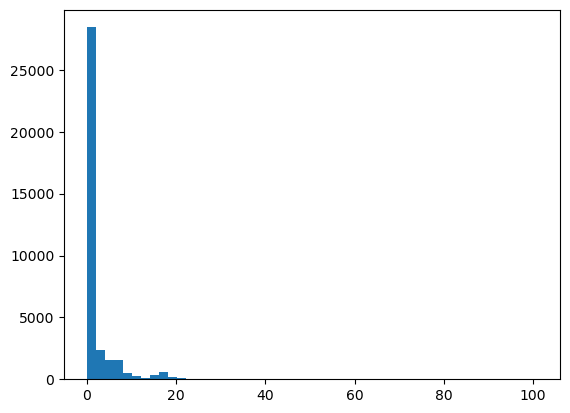

In [32]:
plt.hist(df['cooh'], 50)
plt.show()

<AxesSubplot:xlabel='Source', ylabel='sal'>

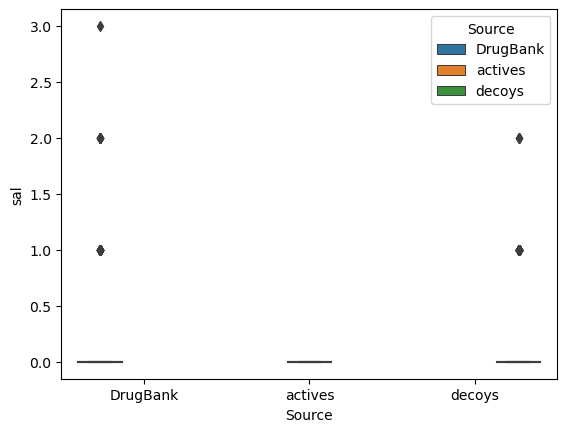

In [37]:
sb.boxplot(x='Source', y='sal', hue='Source', data=df)

In [41]:
df[(df['Source'] == 'DrugBank') & (df['cooh'] > 0)]

,Mol,Source,cooh,ar,sal
0,<rdkit.Chem.rdchem.Mol object at 0x7f5c02b6f670>,DrugBank,6,3,0
9,<rdkit.Chem.rdchem.Mol object at 0x7f5c02b6f940>,DrugBank,2,1,0
10,<rdkit.Chem.rdchem.Mol object at 0x7f5c02b6f990>,DrugBank,1,0,0
11,<rdkit.Chem.rdchem.Mol object at 0x7f5c02b6f9e0>,DrugBank,1,0,0
12,<rdkit.Chem.rdchem.Mol object at 0x7f5c02b6fa30>,DrugBank,1,0,0
...,...,...,...,...,...
7101,<rdkit.Chem.rdchem.Mol object at 0x7f5c02a275d0>,DrugBank,2,0,0
7104,<rdkit.Chem.rdchem.Mol object at 0x7f5c02a277b0>,DrugBank,1,1,0
7106,<rdkit.Chem.rdchem.Mol object at 0x7f5c02a278f0>,DrugBank,1,16,0
7108,<rdkit.Chem.rdchem.Mol object at 0x7f5c02a27a30>,DrugBank,1,0,0


In [42]:
from itertools import chain
# load PAINS structures in SMARTS format from two files in data
pains = []
with open('../data/pains/p_l15.txt', 'r') as f, open('../data/pains/p_m150.txt', 'r') as p:
    for line in chain(f, p):
        pattern, text = line.strip().split('\t') # split by tab
        pains.append([Chem.MolFromSmarts(pattern),
                      text.lstrip("<regId=\"").rstrip("\">")]) # remove the xml tags
pains, len(pains)

([[<rdkit.Chem.rdchem.Mol at 0x7f5c01ce2e90>, 'anil_di_alk_F(14)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f5c01ce2cb0>, 'hzone_anil(14)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f5c01ce2d50>, 'het_5_pyrazole_OH(14)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f5c00e9ea30>, 'het_thio_666_A(13)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f5c01d6ea30>, 'styrene_A(13)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f5c01d6ef30>, 'ne_rhod_C(13)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f5c01cef120>, 'hp_amino_CN_A(13)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f5c01cef6c0>, 'cyano_imine_C(12)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f5c01cef440>, 'thio_urea_A(12)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f5c01cef530>, 'thiophene_amino_B(12)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f5c01cef670>, 'keto_keto_beta_B(12)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f5c01cef710>, 'keto_phenone_A(11)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f5c01cef760>, 'cyano_pyridone_C(11)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f5c01cef850>, 'thiaz_ene_C(11)'],
  [<rdkit.Chem.rdchem.Mol at 0x7f5c01cef940>, '

In [46]:
df['pains_count'] = 0

for p in pains:
    for index, row in df.iterrows():
        if row['Mol'].GetSubstructMatches(p[0]):
            df.loc[df.index == index, 'pains_count'] += 1

df

KeyboardInterrupt: 